In [1]:
import time
import numpy as np

import mss
import cv2
from PIL import Image

import matplotlib.pyplot as plt

from xpc3 import *
from xpc3_helper_sm import *

In [2]:
client = XPlaneConnect()
reset(client, dtpInit=270.0)

# Plotting Functions

In [27]:
def get_pixels(line, sw):
    a, b, c = line
    xs = np.arange(0, sw, 1)
    ys = [-(a / b) * x + (-c / b) for x in xs]
    return xs, ys

def plot_line_in_image(ss, A, B):
    sh, sw, _ = ss.shape
    l = get_pixel_line(A, B, sh, sw)
    xs, ys = get_pixels(l, sw)
    plt.figure(figsize=(10, 6))
    plt.imshow(ss)
    plt.plot(xs, ys, c='lime', linewidth=2.0)
    plt.axis('off')

# World Coordinates

In [6]:
x = client.getDREF("sim/flightmodel/position/local_x")[0]
y = client.getDREF("sim/flightmodel/position/local_z")[0]
z = client.getDREF("sim/flightmodel/position/local_y")[0]

In [33]:
def world_coordinate(pt_local):
    x_local, y_local, z_local = pt_local

    # Translate to home frame
    transx = 35705.5234375 - x_local
    transy = 46269.2578125 - z_local
    transz = y_local - -182.10951232910156

    # Rotate
    rotx, roty = rotateToHome(transx, transy)

    return rotx, roty, transz

In [34]:
l1 = [35929.9796875, -190.48041382, 46803.98203125]
l2 = [35753.2046875, -185.55480957, 46404.71953125]
r1 = [35950.821875, -190.52763977, 46794.65]
r2 = [35773.7703125, -185.58735657, 46395.5515625]

In [35]:
l1w = world_coordinate(l1)
l2w = world_coordinate(l2)
r1w = world_coordinate(r1)
r2w = world_coordinate(r2)

# Pixel Coordinates

In [24]:
def get_pixel_line(A, B, sh, sw):
    # Convert to homogeneous and get Plucker
    Ah = np.append(np.array(A), 1.0)
    Bh = np.append(np.array(B), 1.0)
    L = np.outer(Ah, Bh) - np.outer(Bh, Ah)

    # Get projection matrix
    mv = np.reshape(client.getDREF("sim/graphics/view/world_matrix"), (4, 4)).T
    proj = np.reshape(client.getDREF("sim/graphics/view/projection_matrix_3d"), (4, 4)).T
    proj_3 = np.zeros((3, 4))
    proj_3[:2, :] = proj[:2, :]
    proj_3[2, :] = proj[3, :]
    screen_mat = np.array([[0.5 * sw, 0.0, 0.5 * sw],
                        [0.0, -0.5 * sh, 0.5 * sh],
                        [0.0, 0.0, 1.0]])
    P = screen_mat @ proj_3 @ mv

    lx = P @ L @ P.T
    return np.array([lx[2, 1], lx[0, 2], lx[1, 0]])

In [36]:
setHomeState(client, 0, 270, 0)
time.sleep(0.2)
screen_shot = mss.mss()
ss = cv2.cvtColor(np.array(screen_shot.grab(
    screen_shot.monitors[2])), cv2.COLOR_BGRA2BGR)[:, :, ::-1]
sh, sw, _ = ss.shape

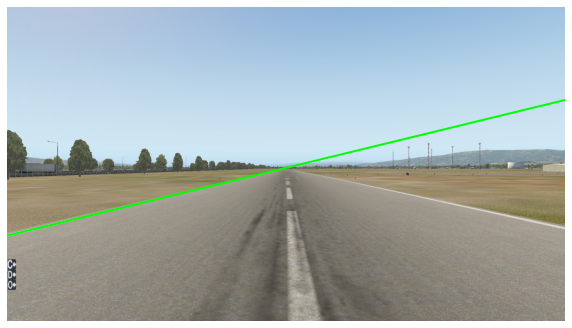

In [37]:
plot_line_in_image(ss, r1, r2)

# Function to go back

In [42]:
def get_plane(A, B, C):
    v1 = A - B
    v2 = C - A
    n = np.cross(v1, v2)
    k = -np.dot(A, n)
    return np.array([n[0], n[1], n[2], k])


ground_plane = get_plane(np.array(r1), np.array(r2), np.array(l1))

In [39]:
def get_plane_int(p1, p2):
    p1_normal = p1[:3]
    p2_normal = p2[:3]

    p3_normal = np.cross(p1_normal, p2_normal)
    det = np.sum(np.square(p3_normal))

    r_point = (np.cross(p3_normal, p2_normal) *
               p1[3] + np.cross(p1_normal, p3_normal) * p2[3]) / det
    r_normal = p3_normal

    return r_point, r_normal

In [43]:
def get_plane(l):
    # Get projection matrix
    mv = np.reshape(client.getDREF("sim/graphics/view/world_matrix"), (4, 4)).T # Gonna need to deal with this
    proj = np.reshape(client.getDREF(
        "sim/graphics/view/projection_matrix_3d"), (4, 4)).T
    proj_3 = np.zeros((3, 4))
    proj_3[:2, :] = proj[:2, :]
    proj_3[2, :] = proj[3, :]
    screen_mat = np.array([[0.5 * sw, 0.0, 0.5 * sw],
                           [0.0, -0.5 * sh, 0.5 * sh],
                           [0.0, 0.0, 1.0]])
    P = screen_mat @ proj_3 @ mv

    return P.T @ l

def get_3d_line(l, ground_plane):
    edge_plane = get_plane(l)
    r_point, r_normal = get_plane_int(edge_plane, ground_plane)
    return r_point, r_normal

In [40]:
line_right = get_pixel_line(r1, r2, sh, sw)
line_right_a, line_right_u = get_3d_line(line_right, ground_plane)

In [52]:
(r1 - line_right_a) / line_right_u

array([3.85965247e-09, 3.85965247e-09, 3.85965247e-09])

In [51]:
line_left = get_pixel_line(l1, l2, sh, sw)
line_left_a, line_left_u = get_3d_line(line_left, ground_plane)

In [53]:
(l1 - line_left_a) / line_left_u

array([3.8304048e-09, 3.8304048e-09, 3.8304048e-09])

In [54]:
line_right_u / line_left_u

array([0.99459877, 0.99279422, 0.99224591])

In [58]:
setHomeState(client, 0, 270, 20)

In [59]:
line_right2 = get_pixel_line(r1, r2, sh, sw)
line_right2_a, line_right2_u = get_3d_line(line_right2, ground_plane)

In [60]:
line_right_u / line_right2_u

array([1.00051374, 1.00051374, 1.00051374])

# Mess Around with Getting H right

In [62]:
setHomeState(client, 0, 270, 0)
time.sleep(0.2)
H0 = np.reshape(client.getDREF("sim/graphics/view/world_matrix"), (4, 4)).T

In [99]:
def get_plane_world(l):
    # Get projection matrix
    # Gonna need to deal with this
    mv = H0
    proj = np.reshape(client.getDREF(
        "sim/graphics/view/projection_matrix_3d"), (4, 4)).T
    proj_3 = np.zeros((3, 4))
    proj_3[:2, :] = proj[:2, :]
    proj_3[2, :] = proj[3, :]
    screen_mat = np.array([[0.5 * sw, 0.0, 0.5 * sw],
                           [0.0, -0.5 * sh, 0.5 * sh],
                           [0.0, 0.0, 1.0]])
    P = screen_mat @ proj_3 @ mv

    return P.T @ l


def get_3d_line(l, ground_plane):
    edge_plane = get_plane_world(l)
    r_point, r_normal = get_plane_int(edge_plane, ground_plane)
    return r_point, r_normal

In [69]:
setHomeState(client, 0, 270, 0)
time.sleep(0.2)
line_right = get_pixel_line(r1, r2, sh, sw)
line_right_a, line_right_u = get_3d_line(line_right, ground_plane)
print((r1 - line_right_a) / line_right_u)
line_left = get_pixel_line(l1, l2, sh, sw)
line_left_a, line_left_u = get_3d_line(line_left, ground_plane)
print((l1 - line_left_a) / line_left_u)

[3.85965247e-09 3.85965247e-09 3.85965247e-09]
[3.8304048e-09 3.8304048e-09 3.8304048e-09]


In [70]:
setHomeState(client, 0, 290, 0)
time.sleep(0.2)
line_right2 = get_pixel_line(r1, r2, sh, sw)
line_right_a, line_right_u = get_3d_line(line_right2, ground_plane)
print((r1 - line_right_a) / line_right_u)
line_left2 = get_pixel_line(l1, l2, sh, sw)
line_left_a, line_left_u = get_3d_line(line_left2, ground_plane)
print((l1 - line_left_a) / line_left_u)

[3.84704792e-09 3.84704375e-09 3.84704248e-09]
[3.81893681e-09 3.81894032e-09 3.81894138e-09]


In [72]:
print(line_right / line_right[2])
print(line_right2 / line_right2[2])

[-3.09240620e-04 -1.27186856e-03  1.00000000e+00]
[-3.0984158e-04 -1.2708257e-03  1.0000000e+00]


# Distance Between Edge Lines

In [73]:
setHomeState(client, 0, 270, 0)
time.sleep(0.2)
line_right = get_pixel_line(r1, r2, sh, sw)
line_right_a, line_right_u = get_3d_line(line_right, ground_plane)
print((r1 - line_right_a) / line_right_u)
line_left = get_pixel_line(l1, l2, sh, sw)
line_left_a, line_left_u = get_3d_line(line_left, ground_plane)
print((l1 - line_left_a) / line_left_u)

[3.85965247e-09 3.85965247e-09 3.85965247e-09]
[3.8304048e-09 3.8304048e-09 3.8304048e-09]


In [94]:
def get_distance_between_lines(p1, l1, p2, l2):
    m1 = np.cross(p1, l1)
    m2 = np.cross(p2, l2)

    num = np.abs(np.dot(l1, m2) + np.dot(l2, m1))
    den = np.linalg.norm(np.cross(l1, l2))

    return num / den

def get_distance_between_lines2(p1, l1, p2, l2):
    s = np.mean(l2 / l1)
    m1 = np.cross(p1, l1)
    m2 = np.cross(p2, l2)

    num = np.linalg.norm(np.cross(l1, m1 - (m2 / s)))
    den = np.linalg.norm(l1)**2

    return num / den


def get_distance_between_lines3(p1, l1, p2, l2):
    n = l1 / np.linalg.norm(l1)
    m = np.cross(p1, n)

    d = np.linalg.norm(np.cross(p2, n) - m)

    return d


def get_distance_between_lines4(p1, l1, p2):
    n = l1 / np.linalg.norm(l1)
    m = np.cross(p1, n)

    d = np.linalg.norm(np.cross(p2, n) - m)

    return d


In [82]:
get_distance_between_lines(line_right_a, line_right_u / line_right_u[2], line_left_a, line_left_u / line_left_u[2])

5.416053701424344e-11

In [89]:
get_distance_between_lines2(line_right_a, line_right_u / np.linalg.norm(line_right_u), line_left_a, 
                            line_left_u / np.linalg.norm(line_left_u[2]))


35.60018515387713

In [84]:
get_distance_between_lines2(line_right_a, line_right_u, line_left_a, line_left_u)

35.600185153880396

In [93]:
get_distance_between_lines3(line_right_a, line_right_u, line_left_a, line_left_u)


27.460819118906667

In [95]:
get_distance_between_lines4(line_right_a, line_right_u, l1)

22.83593101580987

In [87]:
np.linalg.norm(np.array([r1]) - np.array([l1]))

22.836063963091924

In [97]:
c1 = (np.array([l1]) + np.array([r1])) / 2

In [98]:
get_distance_between_lines4(line_right_a, line_right_u, c1)

11.417965507841265

# Try moving it over and getting crosstrack

In [127]:
setHomeState(client, 10, 270, 0)
time.sleep(0.2)
line_right = get_pixel_line(r1, r2, sh, sw)
line_right_a, line_right_u = get_3d_line(line_right, ground_plane)
print((r1 - line_right_a) / line_right_u)
line_left = get_pixel_line(l1, l2, sh, sw)
line_left_a, line_left_u = get_3d_line(line_left, ground_plane)
print((l1 - line_left_a) / line_left_u)

[0. 0. 0.]
[0. 0. 0.]


In [128]:
11.417965507841265 - get_distance_between_lines4(line_right_a, line_right_u, c1)

9.995846420605659

In [104]:
# Check how much K changes when moving
setHomeState(client, 0, 270, 0)
time.sleep(0.2)
proj = np.reshape(client.getDREF(
    "sim/graphics/view/projection_matrix_3d"), (4, 4)).T
proj_3 = np.zeros((3, 4))
proj_3[:2, :] = proj[:2, :]
proj_3[2, :] = proj[3, :]
screen_mat = np.array([[0.5 * sw, 0.0, 0.5 * sw],
                       [0.0, -0.5 * sh, 0.5 * sh],
                       [0.0, 0.0, 1.0]])
K1 = screen_mat @ proj_3

In [117]:
setHomeState(client, 0, 270, 0)
time.sleep(0.2)
proj = np.reshape(client.getDREF(
    "sim/graphics/view/projection_matrix_3d"), (4, 4)).T
proj_3 = np.zeros((3, 4))
proj_3[:2, :] = proj[:2, :]
proj_3[2, :] = proj[3, :]
screen_mat = np.array([[0.5 * sw, 0.0, 0.5 * sw],
                       [0.0, -0.5 * sh, 0.5 * sh],
                       [0.0, 0.0, 1.0]])
K2 = screen_mat @ proj_3

In [116]:
np.set_printoptions(suppress=True)
print(K1)
print(K2)

[[ 1144.08348083     0.          -960.             0.        ]
 [    0.         -1144.08333778  -540.             0.        ]
 [    0.             0.            -1.             0.        ]]
[[ 1144.08336639     0.          -960.             0.        ]
 [    0.         -1144.08333778  -540.             0.        ]
 [    0.             0.            -1.             0.        ]]


# Mess with Rotation

In [184]:
setHomeState(client, 0, 270, 10)
time.sleep(0.2)
line_right = get_pixel_line(r1, r2, sh, sw)
line_right_a, line_right_u = get_3d_line(line_right, ground_plane)
print((r1 - line_right_a) / line_right_u)
line_left = get_pixel_line(l1, l2, sh, sw)
line_left_a, line_left_u = get_3d_line(line_left, ground_plane)
print((l1 - line_left_a) / line_left_u)

[3.69282991e-09 3.66734271e-09 3.66304574e-09]
[3.61053316e-09 3.58660550e-09 3.58250644e-09]


In [177]:
11.417965507841265 - get_distance_between_lines4(line_right_a, line_right_u, c1)

-79.01828340210494

In [178]:
def get_rot_mat(theta):
    return np.array([[np.cos(theta), 0.0, np.sin(theta)],
                     [0.0, 1.0, 0.0],
                     [-np.sin(theta), 0.0, np.cos(theta)]])

def get_rot_line(a, u, theta):
    R = get_rot_mat(theta)
    return R @ a, R @ u

In [179]:
line_right_arot, line_right_urot = get_rot_line(line_right_a, line_right_u, -10)

In [180]:
np.set_printoptions(suppress=False)
(r1 - line_right_arot) / line_right_urot

array([ 1.20496582e-08,  3.66734271e-09, -3.91902641e-09])

In [181]:
setHomeState(client, 0, 270, 0)
time.sleep(0.2)
line_right0 = get_pixel_line(r1, r2, sh, sw)
line_right0_a, line_right0_u = get_3d_line(line_right0, ground_plane)
print((r1 - line_right0_a) / line_right0_u)
line_left0 = get_pixel_line(l1, l2, sh, sw)
line_left0_a, line_left0_u = get_3d_line(line_left0, ground_plane)
print((l1 - line_left_a) / line_left_u)

[3.85965247e-09 3.85965247e-09 3.85965247e-09]
[3.61053316e-09 3.58660550e-09 3.58250644e-09]


In [182]:
line_right0_u / line_right0_u[2]

array([ 0.4436288 , -0.01237861,  1.        ])

In [185]:
R = get_rot_mat(-10 * np.pi / 180)
rot_line = R @ line_right_u
np.dot(rot_line / rot_line[2], line_right0_u / line_right0_u[2])
rot_line / rot_line[2]

array([ 0.06636609, -0.01079211,  1.        ])